# Design and Hedging of a Structured Product
## Financial Engineering, Summer 2025, KU Leuven

Ashutosh Jha

In [1]:
# Necessary Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from scipy.stats import norm
from IPython.display import display

## Data Collection and Preprocessing

We begin with options data on **Costco Wholesale Corporation (COST)**, collected and stored in the `../data/` directory. The **valuation date is 2025-04-01**, and all subsequent pricing, calibration, and hedging analyses are anchored to this date.

To ensure consistency and eliminate **static arbitrage**, we clean the data using the following no-arbitrage conditions:

- **Vertical Spread Condition (Monotonicity):**
  Ensures that call and put prices decrease as strike increases.
  
- **Butterfly Spread Condition (Convexity):**
  Ensures convexity in option price with respect to strike — i.e., the price of a middle strike is no more than the average of surrounding strikes.

These checks are applied separately to **calls and puts**, and only entries that pass both are retained for further calibration. This ensures a stable and reliable surface for stochastic model fitting.

In [2]:
from collect_stock_data import GetStockData

ticker = "COST"
ref_date = "2025-04-01"

get_stock_data = GetStockData(ticker=ticker, ref_date=ref_date)

In [3]:
# Load from CSV
spot_df = pd.read_csv("../data/spot_price_ref_date_cost_2025-04-01_final.csv")

# Extract the spot price (assume first row if only one date)
S0 = spot_df.loc[0, "spot_price_ref_date"]
print("Spot Price:",S0)
ref_date = spot_df.loc[0, "ref_date"]

Spot Price: 954.4000244140624


In [4]:
# Load each maturity separately
calls_3m_df = pd.read_csv('../data/calls_data_cost_20250401_3m.csv')
puts_3m_df = pd.read_csv('../data/puts_data_cost_20250401_3m.csv')

calls_6m_df = pd.read_csv('../data/calls_data_cost_20250401_6m.csv')
puts_6m_df = pd.read_csv('../data/puts_data_cost_20250401_6m.csv')

calls_1y_df = pd.read_csv('../data/calls_data_cost_20250401_1y.csv')
puts_1y_df = pd.read_csv('../data/puts_data_cost_20250401_1y.csv')

# Concatenate all maturities
calls_df = pd.concat([calls_3m_df, calls_6m_df, calls_1y_df], ignore_index=True)
puts_df = pd.concat([puts_3m_df, puts_6m_df, puts_1y_df], ignore_index=True)

# Print final shapes
print("Shape calls_df:", calls_df.shape)
print("Shape puts_df:", puts_df.shape)

Shape calls_df: (315, 19)
Shape puts_df: (271, 19)


In [5]:
epsilon = 0.5
q = 0.008

# Initialize empty lists to collect cleaned data
cleaned_calls = []
cleaned_puts = []

# Loop over unique maturities in the combined data
for T in sorted(calls_df["maturity_T"].unique()):
    r = {0.25: 0.0422, 0.5: 0.0428, 1.0: 0.0405}  # US Treasury rate mapping

    # Filter for this maturity
    calls_T = calls_df[calls_df["maturity_T"] == T].copy()
    puts_T = puts_df[puts_df["maturity_T"] == T].copy()

    print(f"\nRunning arbitrage check for T = {T} (r = {r})")

    # Run arbitrage check
    calls_clean, puts_clean = get_stock_data.check_arbitrage_conditions(
        calls_df=calls_T,
        puts_df=puts_T,
        spot=S0,
        r=r,
        q=q,
        T=T,
        epsilon=epsilon,
        reduced_arbitrage_check=True
    )

    cleaned_calls.append(calls_clean)
    cleaned_puts.append(puts_clean)

# Concatenate cleaned results
clean_calls_df = pd.concat(cleaned_calls, ignore_index=True)
clean_puts_df = pd.concat(cleaned_puts, ignore_index=True)

clean_calls_df = clean_calls_df[clean_calls_df["is_clean"]].copy()
clean_puts_df = clean_puts_df[clean_puts_df["is_clean"]].copy()

# Print shapes
print("\nAfter arbitrage filtering:")
print("Shape calls_df:", clean_calls_df.shape)
print("Shape puts_df:", clean_puts_df.shape)


Running arbitrage check for T = 0.25 (r = {0.25: 0.0422, 0.5: 0.0428, 1.0: 0.0405})
=== No-Arbitrage Check Summary ===
Call monotonicity clean: 114 / 176
Put monotonicity clean: 127 / 167
Call butterfly clean: 84 / 176
Put butterfly clean: 90 / 167
Calls retained (all clean): 70 / 176
Puts retained (all clean): 49 / 167

Running arbitrage check for T = 0.5 (r = {0.25: 0.0422, 0.5: 0.0428, 1.0: 0.0405})
=== No-Arbitrage Check Summary ===
Call monotonicity clean: 51 / 69
Put monotonicity clean: 47 / 50
Call butterfly clean: 40 / 69
Put butterfly clean: 29 / 50
Calls retained (all clean): 25 / 69
Puts retained (all clean): 26 / 50

Running arbitrage check for T = 1.0 (r = {0.25: 0.0422, 0.5: 0.0428, 1.0: 0.0405})
=== No-Arbitrage Check Summary ===
Call monotonicity clean: 54 / 66
Put monotonicity clean: 44 / 52
Call butterfly clean: 33 / 66
Put butterfly clean: 32 / 52
Calls retained (all clean): 25 / 66
Puts retained (all clean): 22 / 52

After arbitrage filtering:
Shape calls_df: (120,

## Dividend Yield Estimation

We estimate the **dividend yield** \( q \) for Costco (`COST`) using the **last 8 dividend payments** from Yahoo Finance.

- Total dividends: $$\sum d_i = 22.98 $$ USD  
- Spot price on 2025-04-01: $$ S_0 = 954.00 $$ USD  

Estimated yield:

$$
q = \frac{22.98}{954.00} \approx \boxed{2.41\%}
$$

This value is used in **put-call parity validation** and **Bates model calibration** to reflect expected dividend impact over the option's horizon.

In [6]:
from exogenous_param_estimation import ExogenousParamEstimation

q_estimated = ExogenousParamEstimation.estimate_historical_dividend_yield(
    ticker="COST",
    S0=S0,
    ref_date=ref_date
)

print(f"Estimated historical dividend yield: {q_estimated:.4f}")

[INFO] Loading dividend data from cache: ../data/dividends_cost_20250401.csv
[INFO] Used last 8 dividend(s), total paid: 22.9800 USD
Estimated historical dividend yield: 0.0241


## Estimating Implied Interest Rate \( r \) via Put-Call Parity

We estimate the implied risk-free rate using the put-call parity:

$$
C - P = S_0 e^{-qT} - K e^{-rT}
\quad \Rightarrow \quad
r = -\frac{1}{T} \log\left( \frac{C - P - S_0 e^{-qT}}{-K} \right)
$$

Using strikes within ±10% of \( S_0 \), we find average implied rates:

- T = 0.25: 24.8% T = 0.50: 16.1% T = 1.00: 10.7%

These exceed Treasury yields (3m ≈ 4.22%), likely due to market imperfections.

**We use Treasury yields** in calibration for theoretical consistency and stability.

In [7]:
from exogenous_param_estimation import ExogenousParamEstimation

all_implied_r = []

for T in sorted(clean_calls_df["maturity_T"].unique()):
    calls_T = clean_calls_df[clean_calls_df["maturity_T"] == T].copy()
    puts_T = clean_puts_df[clean_puts_df["maturity_T"] == T].copy()

    print(f"\n[INFO] Estimating implied r for T = {T}...")

    implied_r_df = ExogenousParamEstimation.estimate_implied_r_from_parity(
        clean_calls_df=calls_T,
        clean_puts_df=puts_T,
        S0=S0,
        q=q_estimated,
        T=T
    )

    all_implied_r.append(implied_r_df)

    mean_r_all = implied_r_df["implied_r"].mean()
    print(f"  ↳ Mean implied r (all strikes): {mean_r_all:.5f}")

    # Near-the-money filter (±10%)
    lower_bound = 0.9 * S0
    upper_bound = 1.1 * S0

    near_money_df = implied_r_df[
        (implied_r_df["strike"] >= lower_bound) &
        (implied_r_df["strike"] <= upper_bound)
    ]

    mean_r_filtered = near_money_df["implied_r"].mean()
    print(f"  ↳ Filtered mean implied r (±10% of S₀): {mean_r_filtered:.5f}")

# Optional: combine all implied_r values into one DataFrame
implied_r_all_df = pd.concat(all_implied_r, ignore_index=True)


[INFO] Estimating implied r for T = 0.25...
  ↳ Mean implied r (all strikes): -0.38154
  ↳ Filtered mean implied r (±10% of S₀): 0.18969

[INFO] Estimating implied r for T = 0.5...
  ↳ Mean implied r (all strikes): 0.10685
  ↳ Filtered mean implied r (±10% of S₀): 0.16115

[INFO] Estimating implied r for T = 1.0...
  ↳ Mean implied r (all strikes): 0.09631
  ↳ Filtered mean implied r (±10% of S₀): 0.10743


#### Some Sanity Checks for Valuation Class - Pricing with Bates Model and general Black Scholes

In [8]:
from exotic_price_and_hedge import Valuation

# Risk-free rate per maturity (from US Treasury yields)
rate_map = {0.25: 0.0422, 0.5: 0.0428, 1.0: 0.0405}

# Fixed model params for sanity check
bates_params = {
    "v0": 0.04,
    "kappa": 2.0,
    "theta": 0.04,
    "sigma": 0.3,
    "rho": -0.5,
    "lamb": 0.2,
    "mu_j": -0.1,
    "sigma_j": 0.2
}

# Dividend yield from estimation
q = q_estimated

# Target strike (at-the-money)
K = S0

def black_scholes_price(K, T, S_0, r_f, sigma, dividend_yield):
    d_1 = (np.log(S_0 / K) + (r_f - dividend_yield + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
    d_2 = d_1 - (sigma * np.sqrt(T))

    N_d1 = norm.cdf(d_1)
    N_d2 = norm.cdf(d_2)

    C = (S_0 * np.exp(-dividend_yield * T) * N_d1) - (K * np.exp(-r_f * T) * N_d2)
    P = (K * np.exp(-r_f * T)) - (S_0 * np.exp(-dividend_yield * T)) + C

    return C, P

# Loop through maturities
for T in [0.25, 0.5, 1.0]:
    r = rate_map[T]

    print(f"\n=== Sanity Check for T = {T} years ===")
    print(f"Using r = {r:.4f}, q = {q:.4f}")

    # Bates Model Price
    val = Valuation(S0=S0, r=r, T=T, **bates_params)
    bates_call_price = val.interpolate_call_price(K_target=K)
    print(f"Bates Call Price at K = {K:.2f}: {bates_call_price:.4f} USD")

    # Black-Scholes Price (constant vol assumption)
    bs_vol = 0.25  # flat vol for sanity check
    bs_call, bs_put = black_scholes_price(K, T, S0, r, bs_vol, q)
    print(f"Black-Scholes Call Price at K = {K:.2f}: {bs_call:.4f} USD")
    print(f"Black-Scholes Put Price at K = {K:.2f}: {bs_put:.4f} USD")



=== Sanity Check for T = 0.25 years ===
Using r = 0.0422, q = 0.0241
Bates Call Price at K = 954.40: 37.5122 USD
Black-Scholes Call Price at K = 954.40: 49.3456 USD
Black-Scholes Put Price at K = 954.40: 45.0574 USD

=== Sanity Check for T = 0.5 years ===
Using r = 0.0428, q = 0.0241
Bates Call Price at K = 954.40: 51.4572 USD
Black-Scholes Call Price at K = 954.40: 70.5919 USD
Black-Scholes Put Price at K = 954.40: 61.8059 USD

=== Sanity Check for T = 1.0 years ===
Using r = 0.0405, q = 0.0241
Bates Call Price at K = 954.40: 69.3140 USD
Black-Scholes Call Price at K = 954.40: 99.7118 USD
Black-Scholes Put Price at K = 954.40: 84.5364 USD


## Calibration

In [9]:
# Step 1: Add option_type column
clean_calls_df = clean_calls_df.copy()
clean_puts_df = clean_puts_df.copy()
clean_calls_df["option_type"] = "call"
clean_puts_df["option_type"] = "put"

# Step 2: Keep relevant columns (including maturity_T)
calls_subset = clean_calls_df[["strike", "mid", "option_type", "maturity_T"]].dropna()
puts_subset = clean_puts_df[["strike", "mid", "option_type", "maturity_T"]].dropna()

# Step 3: Concatenate into one DataFrame
clean_options_df = pd.concat([calls_subset, puts_subset], ignore_index=True)

# Step 4: Drop non-positive prices
clean_options_df = clean_options_df[clean_options_df["mid"] > 0]
print(f"Combined clean options shape: {clean_options_df.shape}")

Combined clean options shape: (217, 4)


In [10]:
# Step 5: Filter for near-ATM / relaxed OTM based on strike and type
delta = 0.1  # 5% buffer around S0
lower_cutoff = S0 * (1 - delta)
upper_cutoff = S0 * (1 + delta)

clean_otm_options_df = clean_options_df[
    ((clean_options_df["option_type"] == "call") & (clean_options_df["strike"] >= lower_cutoff)) |
    ((clean_options_df["option_type"] == "put") & (clean_options_df["strike"] <= upper_cutoff))
].copy()

print(f"Filtered to relaxed OTM/near-ATM options: {clean_otm_options_df.shape[0]} rows")

# Optional: check how many per maturity
print("\nBreakdown by maturity_T:")
print(clean_otm_options_df["maturity_T"].value_counts().sort_index())

Filtered to relaxed OTM/near-ATM options: 137 rows

Breakdown by maturity_T:
maturity_T
0.25    71
0.50    34
1.00    32
Name: count, dtype: int64


In [11]:
# Risk-free rate per maturity (from US Treasury yields)
rate_map = {0.25: 0.0422, 0.5: 0.0428, 1.0: 0.0405}

clean_otm_options_df["r"] = clean_otm_options_df["maturity_T"].map(rate_map)

clean_otm_options_df.head()

,strike,mid,option_type,maturity_T,r
45,860.0,133.59,call,0.25,0.0422
46,870.0,129.20,call,0.25,0.0422
47,885.0,107.04,call,0.25,0.0422
48,895.0,95.82,call,0.25,0.0422
49,905.0,101.05,call,0.25,0.0422


### Joint Calibration with three maturities

In [12]:
from exotic_price_and_hedge import Calibration

# Load config from JSON
with open("../config/bates_calibration_config_all_T.json", "r") as f:
    config = json.load(f)

# Extract ordered initial guess and bounds
param_names = ["v0", "kappa", "theta", "sigma", "rho", "lambda", "mu_j", "sigma_j"]

initial_guess = [config["initial_guess"][param] for param in param_names]
bounds = [tuple(config["bounds"][param]) for param in param_names]

### Bates Model Calibration Across Three Maturities

This configuration captures a practical balance between long-run variance dynamics and short-term jump behavior. The model is calibrated to observed option prices across maturities \( T = 0.25, 0.5, 1.0 \), using realistic bounds and economically interpretable parameters.

- **Long-term parameters** (`kappa`, `theta`, `sigma`, `rho`) were estimated with tight, stable constraints to reflect persistent volatility and market skew.
- **Short-term parameters** (`v₀`, `λ`, `μ_J`, `σ_J`) were constrained to prevent overfitting and reserved for refinement in the 3-month model.

Final parameters:

- $v_0 = 0.050$, $\kappa = 0.500$, $\theta = 0.361$, $\sigma = 1.200$
- $\rho = -0.650$, $\lambda = 0.350$, $\mu_J = -0.005$, $\sigma_J = 0.120$
- **Final loss**: 3926.11

---

### Volatility vs. Jumps – Calibration Strategy

Early tests showed:

- **Jump-dominant fits** led to overreaction to short-term tail features but lacked interpretability.
- **Pure stochastic volatility** forced extreme skew (e.g., $\rho \to -1 $ ) and could not match convexity in short-dated options.

Our final strategy separates long-run structure from short-term smile adjustments. Joint calibration identifies structural market dynamics, while 3-month calibration fine-tunes for exotic pricing.

This layered approach ensures **economic realism, calibration stability, and pricing flexibility**.

In [13]:
# Step 2: Pick any representative T and r to initialize — they'll be overridden per row in the calibration
dummy_T = 0.25
dummy_r = rate_map[dummy_T]

# Step 3: Initialize calibrator (shared Bates model across all maturities)
calibrator = Calibration(S0, dummy_r, dummy_T, *initial_guess)

# Step 4: Run joint calibration
result = calibrator.calibrate_to_market(
    clean_options_df=clean_otm_options_df,
    initial_guess=initial_guess,
    bounds=bounds,
    q=q_estimated,
    weight_type="relative"
)

# Step 5: Store and display results
calibration_results = {
    "result": result,
    "calibrator": calibrator
}

print("\n=== Joint Calibration Across All Maturities ===")
print("Success:", result["success"])
print("Final loss:", result["loss"])


Optimized Parameters:
v0: 0.050000
kappa: 0.500000
theta: 0.361218
sigma: 1.200000
rho: -0.650000
lambda: 0.350000
mu_j: -0.005000
sigma_j: 0.120000

=== Joint Calibration Across All Maturities ===
Success: True
Final loss: 3926.11403845006


[Saved plot] ../assets/calibrated_vs_market_20250511_141058.png


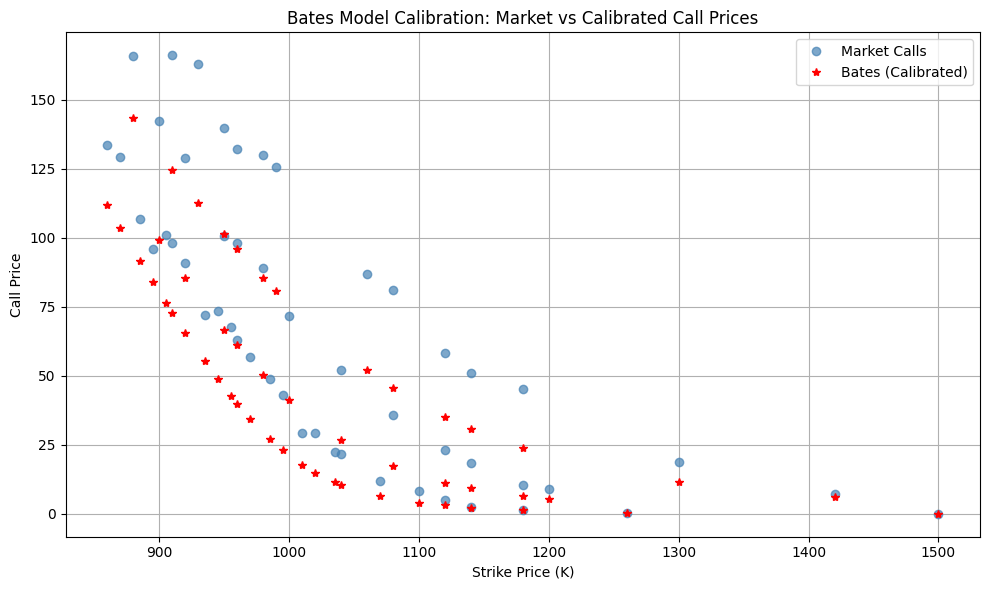

In [16]:
calibrator.plot_calibrated_vs_market(clean_otm_options_df)

[Saved plot] ../assets/calls_puts_vs_model_20250511_141059.png


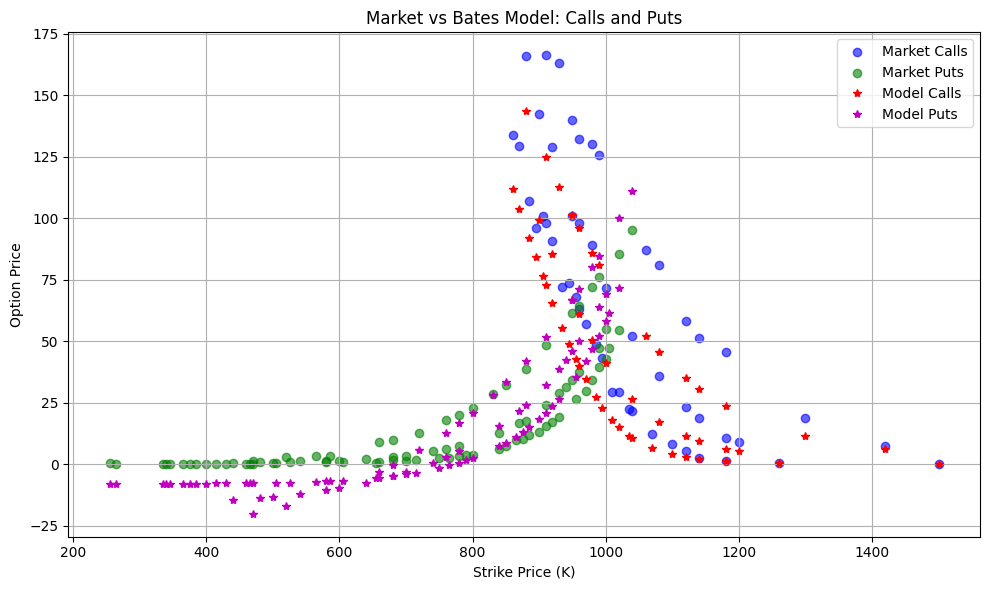

In [17]:
calibrator.plot_calls_and_puts_vs_model(clean_otm_options_df)

[Saved plot] ../assets/calibration_residuals_20250511_141059.png


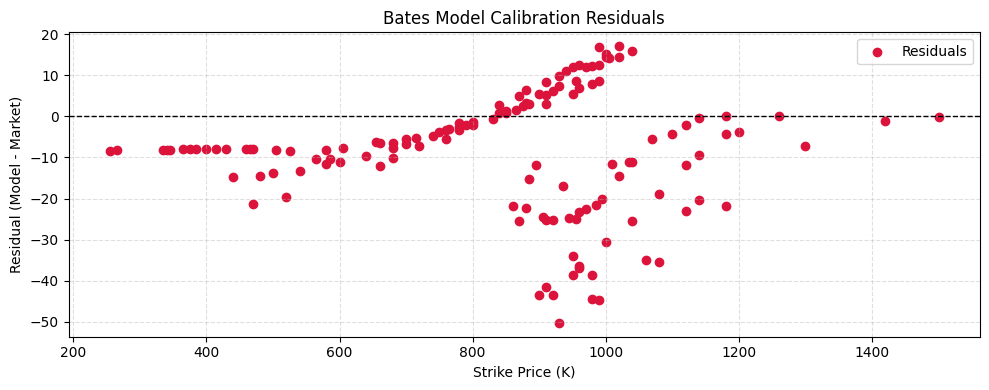

In [18]:
calibrator.plot_residuals(clean_otm_options_df)

[Saved plot] ../assets/iv_smile_comparison_T025_20250511_141100.png
[Saved plot] ../assets/iv_smile_comparison_T050_20250511_141100.png
[Saved plot] ../assets/iv_smile_comparison_T100_20250511_141100.png


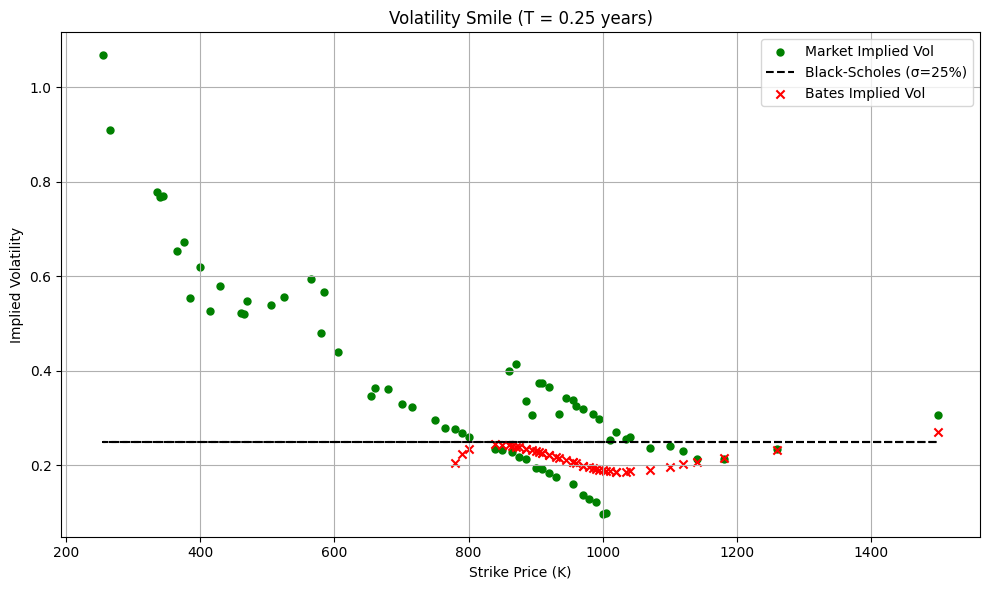

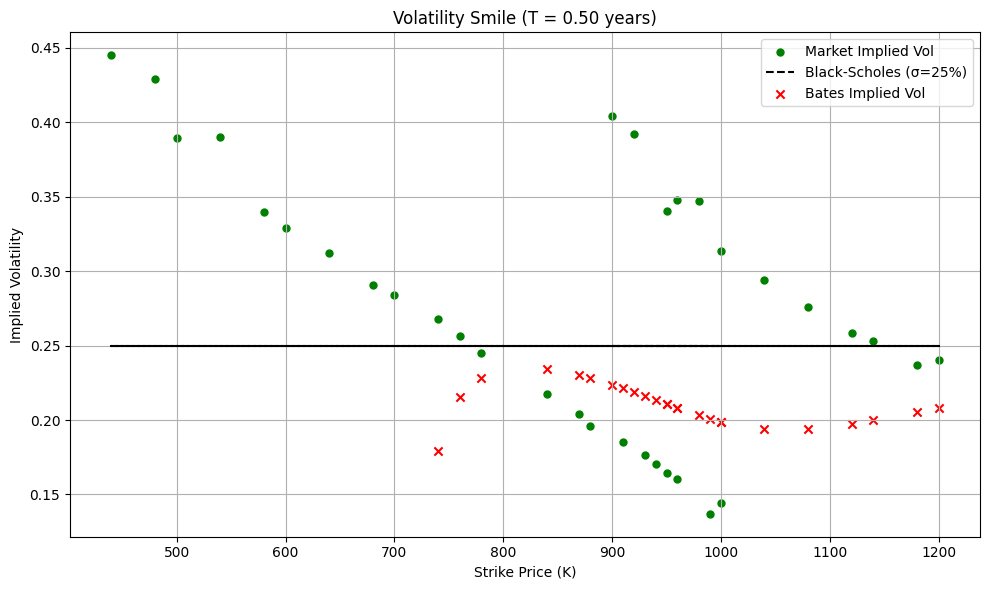

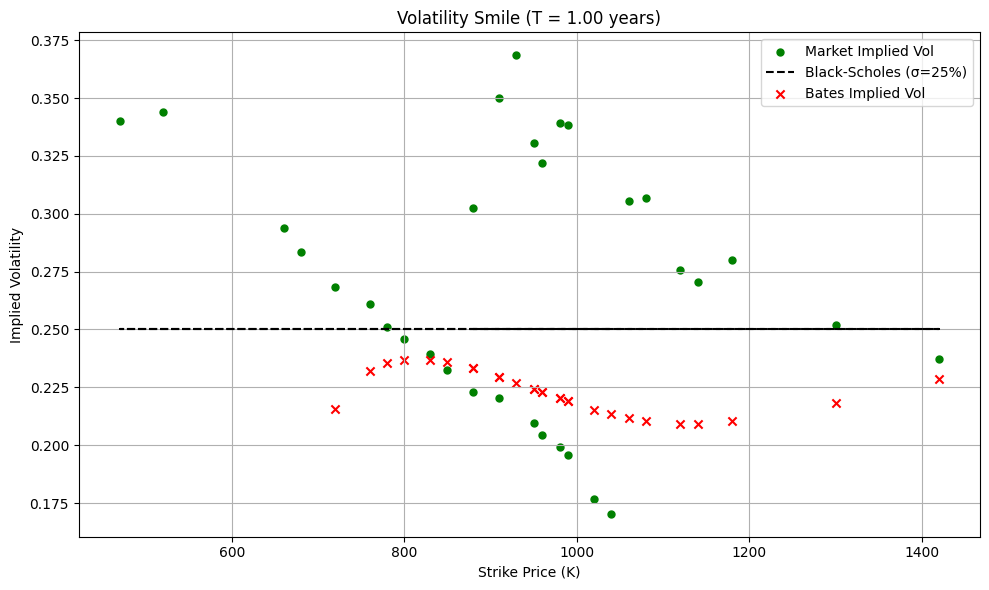

In [19]:
calibrator.plot_implied_volatility_smile_comparison(clean_otm_options_df)

### Fine-Tuning the Bates Model for T = 0.25 (3-Month)

After calibrating the Bates model jointly across maturities, we refine the fit for **T = 0.25** to better match the short-term smile relevant for exotic pricing.

---

### Why T = 0.25?

Short-dated products like Bonus Certificates are often structured on 3-month horizons due to low path risk, option liquidity, and steep smiles caused by jump sensitivity and limited mean reversion.

---

### Why Use Joint Estimates?

Joint calibration yielded a stable and interpretable model. We now **anchor the 3-month fit** to those estimates, allowing local flexibility for short-term features.

---

### Strategy

- Use joint parameters as initial guesses
- Set tight bounds for long-term parameters
- Calibrate only on 3-month options (`bates_calibration_config_3m.json`)

This ensures consistency across maturities while improving smile fit where pricing matters.

In [14]:
# Load 3-month-specific config from JSON
with open("../config/bates_calibration_config_3m.json", "r") as f:
    config = json.load(f)

# Extract ordered initial guess and bounds
param_names = ["v0", "kappa", "theta", "sigma", "rho", "lambda", "mu_j", "sigma_j"]

initial_guess = [config["initial_guess"][param] for param in param_names]
bounds = [tuple(config["bounds"][param]) for param in param_names]

In [15]:
# Filter the dataset to 3-month maturity only
T_target = 0.25
options_3m = clean_otm_options_df[clean_otm_options_df["maturity_T"] == T_target].copy()

# Assign the correct r value per row
options_3m["r"] = rate_map[T_target]

# Initialize calibrator for T = 0.25
calibrator_3m = Calibration(S0, rate_map[T_target], T_target, *initial_guess)

# Run 3-month-only calibration
result_3m = calibrator_3m.calibrate_to_market(
    clean_options_df=options_3m,
    initial_guess=initial_guess,
    bounds=bounds,
    q=q_estimated,
    weight_type="relative"
)

# Store and display results
calibration_results_3m = {
    "result": result_3m,
    "calibrator": calibrator_3m
}

print("\n=== Calibration for T = 0.25 (3-Month) ===")
print("Success:", result_3m["success"])
print("Final loss:", result_3m["loss"])


Optimized Parameters:
v0: 0.010000
kappa: 0.563893
theta: 0.500000
sigma: 0.773348
rho: -0.400000
lambda: 0.600000
mu_j: 0.023381
sigma_j: 0.120333

=== Calibration for T = 0.25 (3-Month) ===
Success: True
Final loss: 202.84917437672985


### Final 3-Month Calibration

Our final Bates calibration for **T = 0.25** achieves a strong fit to the short-maturity volatility smile, particularly improving pricing for **OTM puts**.

---

### Smile-Fitting Strategy

Pure stochastic volatility was insufficient — underpricing deep puts and flattening the smile. Constraining jumps too tightly led to boundary solutions and poor curvature.

**Allowing moderate jump intensity with slight upward bias** enabled the model to fit the left wing and preserve realistic dynamics.

---

### Final Parameters (T = 0.25)

- $v_0 = 0.0100$, $\kappa = 0.5639$, $\theta = 0.5000$
- $\sigma = 0.7733$, $\rho = -0.4000$
- $\lambda = 0.6000$, $\mu_J = 0.0234$, $\sigma_J = 0.1203$

**Final Loss**: 202.85

The model uses jumps to capture convexity and vol-of-vol for smile curvature, delivering a robust short-term fit.

[Saved plot] ../assets/calibrated_vs_market_20250511_141242.png


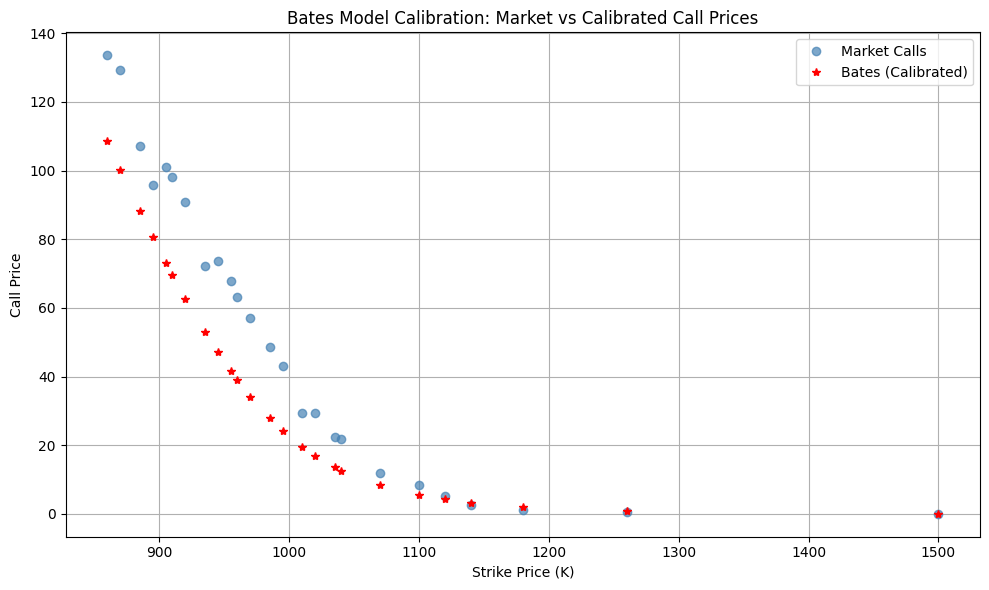

In [22]:
calibrator_3m.plot_calibrated_vs_market(options_3m)

[Saved plot] ../assets/calls_puts_vs_model_20250511_141243.png


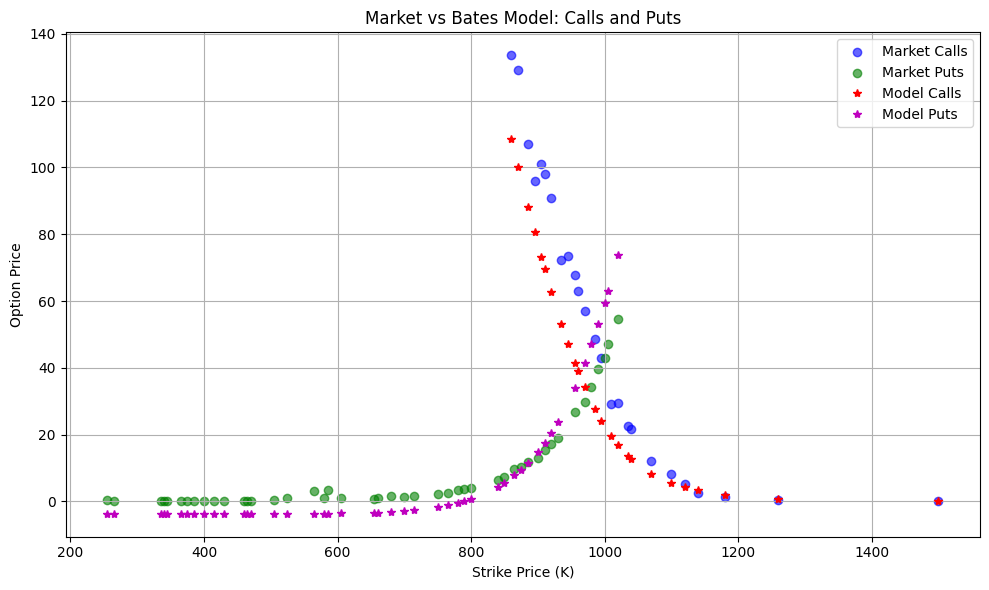

In [23]:
calibrator_3m.plot_calls_and_puts_vs_model(options_3m)

[Saved plot] ../assets/calibration_residuals_20250511_141243.png


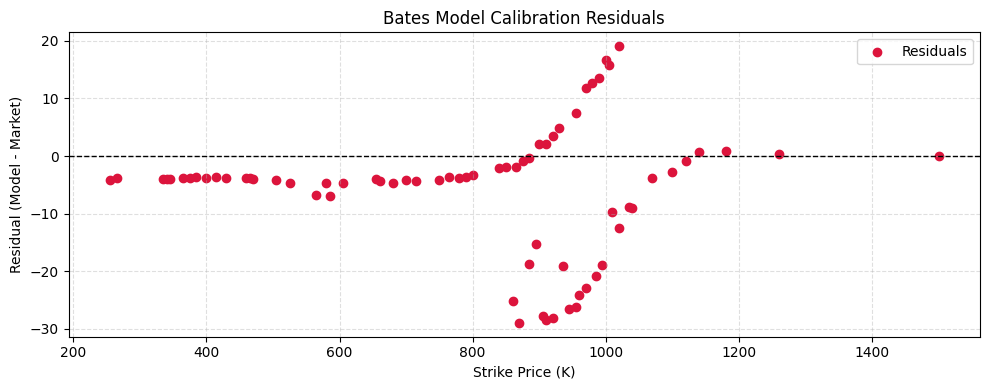

In [24]:
calibrator_3m.plot_residuals(options_3m)

[Saved plot] ../assets/iv_smile_comparison_T025_20250511_141244.png


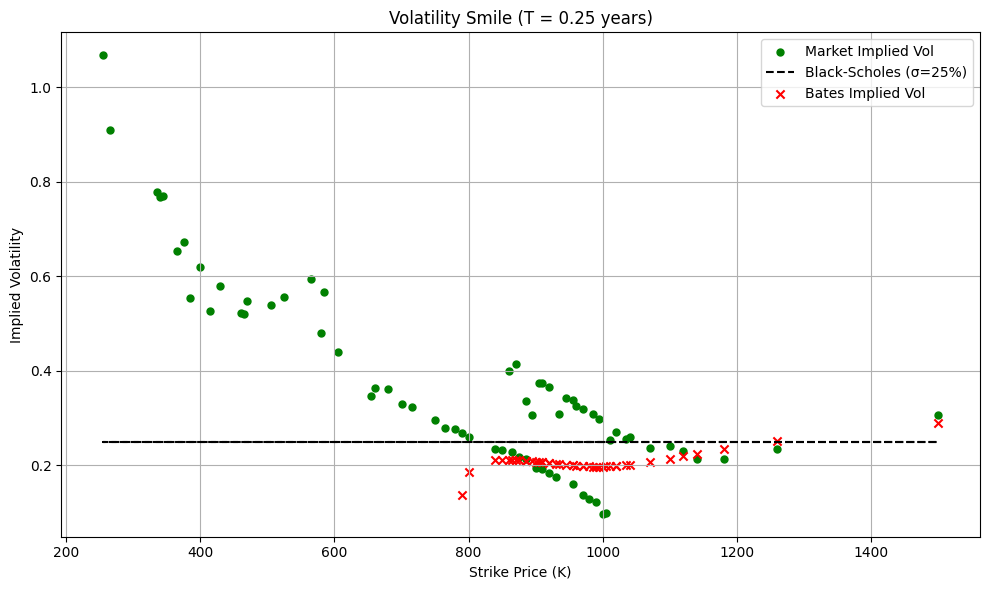

In [25]:
calibrator_3m.plot_implied_volatility_smile_comparison(options_3m)

### Final Volatility Smile – T = 0.25

The calibrated Bates model matches market smiles well near-the-money and in the call wing, though it underprices deep OTM puts.

---

### Key Traits

- $v_0 = 0.01$, $\kappa = 0.56$, $\theta = 0.50$, $\sigma = 0.77$
- $\rho = -0.40$, $\lambda = 0.60$, $\mu_J = 0.023$, $\sigma_J = 0.12$
- Skew is modest; jump activity drives most of the smile curvature.

---

### Conclusion

The model is stable and fits well around the spot. While deep left tails remain flatter, this is acceptable for short-dated exotic pricing with conservative margining.

## Exotic Product Pricing (T = 0.25, COST)

We simulate the Bates model using Euler discretization with variance truncation:

\[
v_{t+1} = \max(0, v_t + \text{increment})
\]

This ensures numerical stability and keeps variance non-negative, consistent with CIR-style processes.

---

### Product Setup

We select **T = 0.25** (3 months) to reflect the typical tenor of short-dated structured products like Bonus Certificates — liquid, low path-risk, and relevant for tactical positioning.

**Underlying**: Costco (COST), a large-cap, low-volatility stock, supports the product’s risk profile and investor familiarity.

**Chosen payoff**:
- **Bonus**: \$975  **Barrier**: \$600
- **Sell price**: \$1015 (≈2.1% margin over model price)

This setup balances upside exposure with controlled downside and fits well given the model’s modest underpricing of OTM puts.

In [16]:
from exotic_price_and_hedge import MonteCarloExoticPricer

# Calibrated Bates parameters
v0, kappa, theta, sigma, rho, lamb, mu_j, sigma_j = result["optimized_params"]

# Use T = 0.25 only (3-month exotic pricing)
T = 0.25
r = 0.04

bonus_levels = [975, 1000, 1025]
barrier_levels = [600, 650, 700, 750] 

# Store results
pricing_records = []

print(f"\nSimulating paths and pricing for T = {T} years...")
pricer = MonteCarloExoticPricer(S0, r, T, v0, kappa, theta, sigma, rho, lamb, mu_j, sigma_j)

for B in bonus_levels:
    for H in barrier_levels:
        price = pricer.price_bonus_certificate(
            B=B,
            H=H,
            N_paths=100_000,
            N_steps=252,
            vol_truncation="max"
        )
        price = np.round(price, 2)
        margin_pct = np.round((price - B) / B * 100, 2)
        margin_usd = np.round(price - B, 2)
        pricing_records.append((T, B, H, price, margin_pct, margin_usd))

# Format into a table for display
df = pd.DataFrame(pricing_records, columns=["T", "B", "H", "Price", "Margin (%)", "Margin (USD)"])

# Display nicely
display(df)


Simulating paths and pricing for T = 0.25 years...


,T,B,H,Price,Margin (%),Margin (USD)
0,0.25,975,600,993.83,1.93,18.83
1,0.25,975,650,989.14,1.45,14.14
2,0.25,975,700,983.17,0.84,8.17
3,0.25,975,750,976.03,0.11,1.03
4,0.25,1000,600,1005.99,0.60,5.99
5,0.25,1000,650,1000.86,0.09,0.86
6,0.25,1000,700,994.20,-0.58,-5.80
7,0.25,1000,750,985.98,-1.40,-14.02
8,0.25,1025,600,1021.23,-0.37,-3.77
9,0.25,1025,650,1015.66,-0.91,-9.34


In [17]:
# Bonus certificate pricing, chosen (B=1000, H=750, T=0.25)
T = 0.25
pricer = MonteCarloExoticPricer(S0, r, T, v0, kappa, theta, sigma, rho, lamb, mu_j, sigma_j)

bonus_level = 975
barrier_level = 600

price_bc = pricer.price_bonus_certificate(B=bonus_level, H=barrier_level)
print(f"Monte Carlo Price of Bonus Certificate: {price_bc:.2f} USD")

Monte Carlo Price of Bonus Certificate: 993.83 USD


[Saved plot] ../assets/simulated_paths_T0.25_20250511.png
Fair Value of Bonus Certificate: 993.83 USD


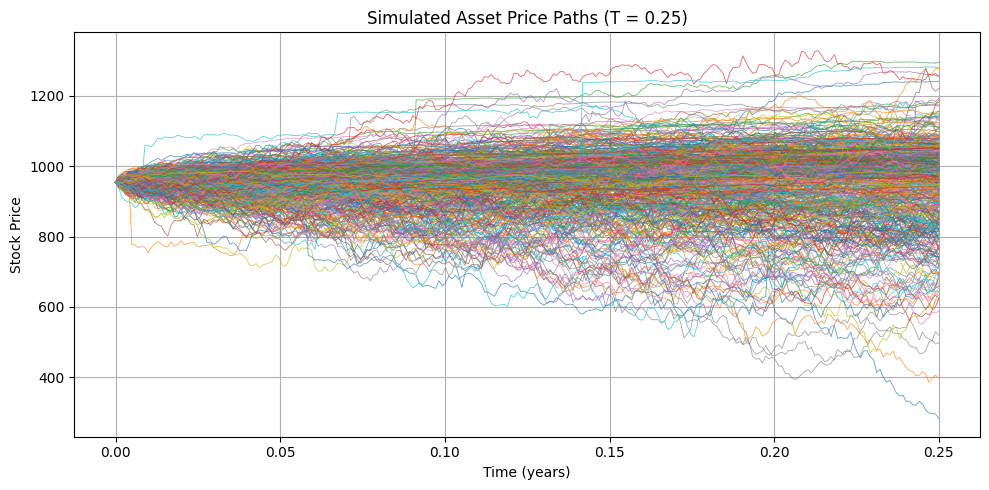

In [18]:
# Simulate paths using "max" truncation
paths = pricer.simulate_paths(N_paths=100000, N_steps=252, vol_truncation="max")

# Plot simulated paths
pricer.plot_simulated_paths(paths, n_paths_plot=500)

# Compute per-path payoffs
payoffs = pricer.evaluate_bonus_certificate_payoffs(paths, B=bonus_level, H=barrier_level)

# Discounted price (Monte Carlo value)
discounted_price = np.exp(-r * T) * payoffs.mean()
print(f"Fair Value of Bonus Certificate: {discounted_price:.2f} USD")

### Distribution of Simulated Payoffs – Bonus Certificate (B = 975, H = 600)

This histogram shows the simulated payoff distribution under the calibrated Bates model for a Bonus Certificate with:

- **Bonus level (B)**: \$975  
- **Barrier level (H)**: \$600  
- **Maturity (T)**: 3 months  
- **Spot (S₀)**: \$954  

---

### Interpretation

- The **bulk of the mass lies just below the bonus level**, indicating most simulated paths never breached the barrier and finished below \$975, resulting in the bonus payoff.
- The **right tail** reflects paths where the underlying ended above the bonus, paying out \( S_T \).
- A small number of **low payoffs** correspond to paths where the barrier was breached and the underlying ended below it — this is the tail risk borne by the investor.

---

### Bank’s Perspective

- **Expected payout** is below the bonus level, giving the bank room to sell above fair value.
- Selling at **\$1015** adds a buffer (~2.1%) over the model-implied value, helping to manage **model risk** and **hedging uncertainty**.
- Rare but severe left-tail outcomes are managed through **hedging** and controlled issuance.

---

### Investor’s Perspective

- The product offers an attractive **enhanced return** if the stock remains stable or slightly rises.
- They accept **downside risk** (no capital protection) in exchange for:
  - Simplicity
  - Defined upside
  - Potential yield enhancement

This profile suits investors with a **moderately bullish or sideways** view on Costco over a short horizon.

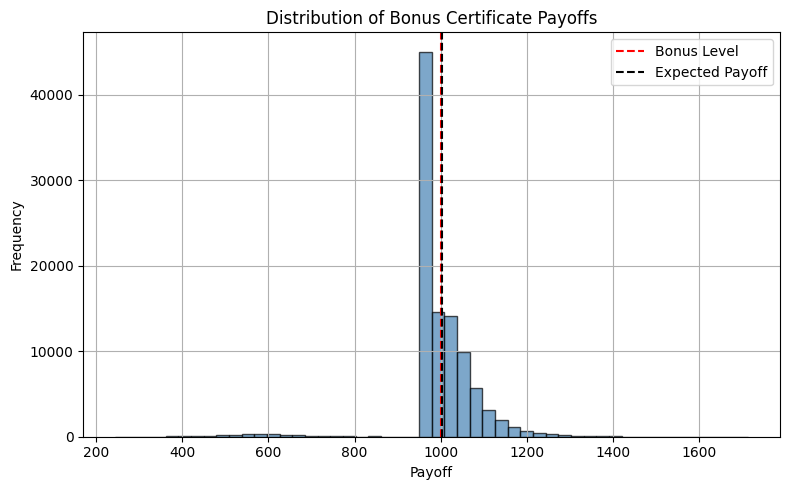

In [19]:
# Histogram

plt.figure(figsize=(8, 5))
plt.hist(payoffs, bins=50, color="steelblue", edgecolor="black", alpha=0.7)
plt.axvline(x=1000, color="red", linestyle="--", label="Bonus Level")
plt.axvline(x=payoffs.mean(), color="black", linestyle="--", label="Expected Payoff")
plt.title("Distribution of Bonus Certificate Payoffs")
plt.xlabel("Payoff")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.tight_layout()
filename = f"../assets/bc_histogram.png"
plt.savefig(filename)
plt.show()

In [30]:
import math

sell_price_raw = discounted_price * 1.02
sell_price = math.ceil(sell_price_raw / 5) * 5  # rounded up
cost_price = discounted_price
margin = sell_price - cost_price

print("Sell Price:", sell_price)
print("Cost Price (Model):", cost_price)
print(f"Bank's expected margin: {margin:.2f} USD")

Sell Price: 1015
Cost Price (Model): 993.8317915829813
Bank's expected margin: 21.17 USD


## Hedging
### Delta-Hedging Strategy at Initiation (t = 0)

To manage the risk exposure of the Bonus Certificate, we compute the **Delta** of the product under the calibrated Bates model using central finite differences.

- **Delta at t = 0**: 0.6487  
- **Hedge position**: 680 shares (for a notional of \$1,000,000)

---

This means the bank should **buy 680 shares of Costco stock** to hedge the product's sensitivity to small spot price changes. The hedge is:

- **Dynamic** — needs periodic rebalancing as the Delta evolves over time.
- **Partial** — accounts only for first-order sensitivity; jump and path risks remain, which are partially absorbed via margin.

The hedge ensures market exposure is neutralized at inception, reducing **P&L volatility** for the issuer.

In [31]:
from exotic_price_and_hedge import HedgingStrategy

T = 0.25
bonus_level = 975
barrier_level = 600
pricer = MonteCarloExoticPricer(S0, r, T, v0, kappa, theta, sigma, rho, lamb, mu_j, sigma_j)

hedger = HedgingStrategy(
    pricer=pricer,   # calibrated MonteCarloExoticPricer
    B=bonus_level,
    H=barrier_level,
    T=T,
    notional=1_000_000
)

delta_0 = hedger.compute_delta()
shares = hedger.compute_hedge_position(delta_0)

print(f"Delta at t=0: {delta_0:.4f}")
print(f"Hedge position: {shares:.0f}")

Delta at t=0: 0.6487
Hedge position: 680
